In [1]:
# ====================================================
# DELHI AIR QUALITY ANALYSIS
# ====================================================
# This notebook analyzes hourly AQI data for Delhi
# to identify pollution patterns, worst days/hours,
# and relationships between pollutants
#-------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

#Make plot nice Look
plt.style.use("seaborn-v0_8")
sns.set_theme()


In [3]:
# Load data
print("Loading Delhi AQI data.....")
df = pd.read_csv("delhiaqi.csv") 

print(f"Dataset shape:{df.shape}")
df.head()
df.info()


Loading Delhi AQI data.....
Dataset shape:(561, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    561 non-null    object 
 1   co      561 non-null    float64
 2   no      561 non-null    float64
 3   no2     561 non-null    float64
 4   o3      561 non-null    float64
 5   so2     561 non-null    float64
 6   pm2_5   561 non-null    float64
 7   pm10    561 non-null    float64
 8   nh3     561 non-null    float64
dtypes: float64(8), object(1)
memory usage: 39.6+ KB


In [5]:
# Parse datetime and create time features
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["hour"] = df["date"].dt.hour
df["dayofweek"] = df["date"].dt.dayofweek  # 0=Mon

print("Time features added!")
df[["date", "hour", "day"]].head()


Time features added!


,date,hour,day
0,2023-01-01 00:00:00,0,1
1,2023-01-01 01:00:00,1,1
2,2023-01-01 02:00:00,2,1
3,2023-01-01 03:00:00,3,1
4,2023-01-01 04:00:00,4,1


In [7]:
#Clean data (handle any missing values)
print("Checking for missing data..")
df.isna().sum()

# Simple cleaning: forward-fill, then back-fill
df = df.ffill().bfill()
print("Data Cleaned")


Checking for missing data..
Data Cleaned


In [9]:
# Create AQI proxy (simplified index from PM2.5 + PM10)
# PM2.5 and PM10 are the main AQI drivers in most cities
df["AQI_proxy"] = df[["pm2_5", "pm10"]].mean(axis=1)

print("AQI proxy created!")
df[["date", "pm2_5", "pm10", "AQI_proxy"]].head()


AQI proxy created!


,date,pm2_5,pm10,AQI_proxy
0,2023-01-01 00:00:00,169.29,194.64,181.965
1,2023-01-01 01:00:00,182.84,211.08,196.960
2,2023-01-01 02:00:00,220.25,260.68,240.465
3,2023-01-01 03:00:00,252.90,304.12,278.510
4,2023-01-01 04:00:00,266.36,322.80,294.580


In [11]:
# Find the most polluted moment
worst_row = df.loc[df["AQI_proxy"].idxmax(), ["date", "AQI_proxy", "pm2_5", "pm10"]]

print("Most polluted hour in the dataset:")
print(f"Date & time : {worst_row['date']}")
print(f"AQI proxy   : {worst_row['AQI_proxy']:.2f}")
print(f"PM2.5       : {worst_row['pm2_5']:.2f}")
print(f"PM10        : {worst_row['pm10']:.2f}")


Most polluted hour in the dataset:
Date & time : 2023-01-19 17:00:00
AQI proxy   : 1404.74
PM2.5       : 1310.20
PM10        : 1499.27


In [15]:
# Worst days (by daily average)
daily_avg = df.groupby(df["date"].dt.date)["AQI_proxy"].mean().sort_values(ascending=False)

print("Top 5 most polluted days (by daily mean AQI proxy):")
for i, (date, val) in enumerate(daily_avg.head().items(), 1):
    print(f"{i}. {date} → {val:.1f}")


Top 5 most polluted days (by daily mean AQI proxy):
1. 2023-01-02 → 764.1
2. 2023-01-13 → 632.1
3. 2023-01-09 → 604.0
4. 2023-01-19 → 568.9
5. 2023-01-01 → 489.5


In [17]:
# Typical worst hours (average across all days)
hourly_avg = df.groupby("hour")["AQI_proxy"].mean().sort_values(ascending=False)

print("Hours of day with highest average AQI proxy:")
for i, (hour, val) in enumerate(hourly_avg.head(6).items(), 1):
    print(f"{i}. {hour}:00 → {val:.1f}")


Hours of day with highest average AQI proxy:
1. 17:00 → 599.7
2. 15:00 → 595.5
3. 16:00 → 588.0
4. 18:00 → 562.2
5. 14:00 → 559.8
6. 13:00 → 485.2


# Research Questions

1. **Key Pollutants**  
   - Which pollutants (PM2.5, PM10, NO2, SO2, O3, CO, NH3) show the highest levels and variability in Delhi?

2. **Temporal / Seasonal Patterns**  
   - How does AQI (proxy) and key pollutants change by **hour of day** and **day of month** (or later by season if data covers more months)?

3. **Pollutant Relationships**  
   - How strongly are PM2.5 and PM10 correlated with gaseous pollutants (NO2, SO2, CO, O3, NH3)?

4. **Geographical / Meteorological Context (qualitative)**  
   - How might Delhi’s landlocked geography, winter inversion, and regional sources (stubble burning, traffic, industry) help explain observed patterns?



In [19]:
# Summary stats for all pollutants
pollutants = ["pm2_5", "pm10", "no2", "so2", "co", "o3", "nh3"]
print("Summary statistics:")
df[pollutants + ["AQI_proxy"]].describe().round(2)


Summary statistics:


,pm2_5,pm10,no2,so2,co,o3,nh3,AQI_proxy
count,561.00,561.00,561.00,561.00,561.00,561.00,561.00,561.00
mean,358.26,420.99,75.29,64.66,3814.94,30.14,26.43,389.62
std,227.36,271.29,42.47,61.07,3227.74,39.98,36.56,248.96
min,60.10,69.08,13.37,5.25,654.22,0.00,0.63,64.59
25%,204.45,240.90,44.55,28.13,1708.98,0.07,8.23,222.94
50%,301.17,340.90,63.75,47.21,2590.18,11.80,14.82,321.55
75%,416.65,482.57,97.33,77.25,4432.68,47.21,26.35,449.59
max,1310.20,1499.27,263.21,511.17,16876.22,164.51,267.51,1404.74


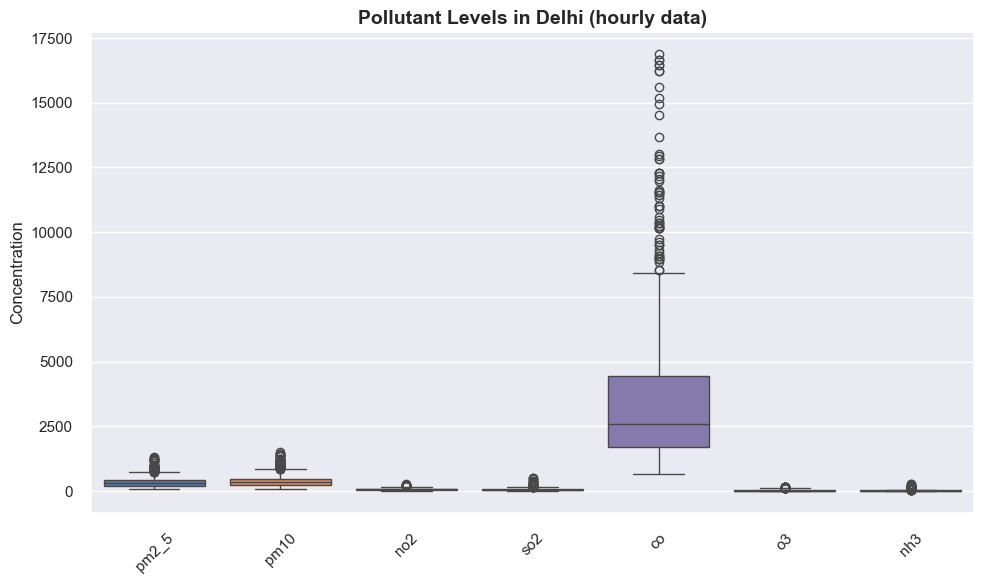

In [21]:
# Boxplot of pollutant distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[pollutants])
plt.title("Pollutant Levels in Delhi (hourly data)", fontsize=14, fontweight="bold")
plt.ylabel("Concentration", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


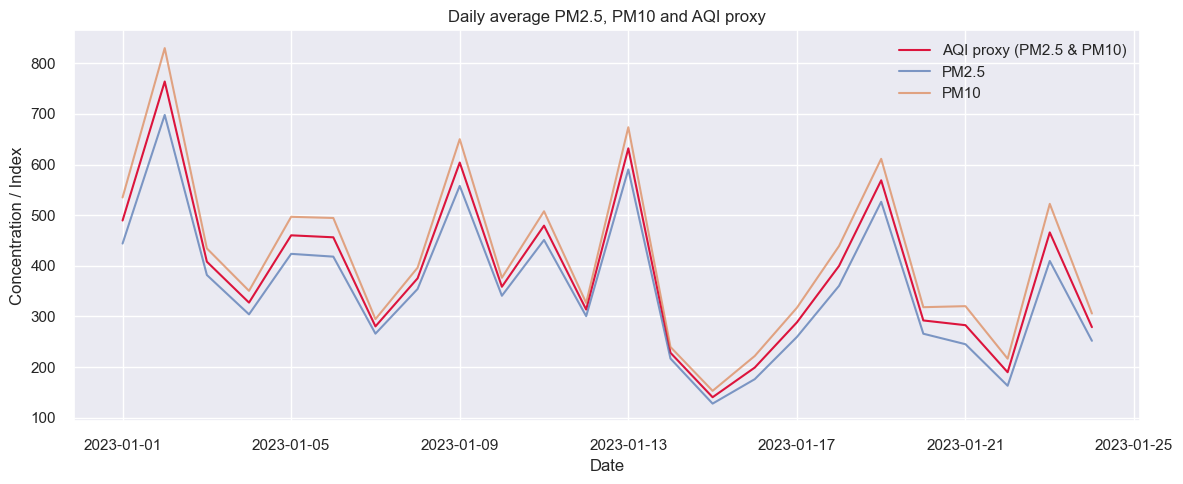

In [23]:
# Resample to daily mean to smooth hourly noise
daily = df.set_index("date").resample("D")[["pm2_5", "pm10", "AQI_proxy"]].mean()

plt.figure(figsize=(12, 5))
plt.plot(daily.index, daily["AQI_proxy"], label="AQI proxy (PM2.5 & PM10)", color="crimson")
plt.plot(daily.index, daily["pm2_5"], label="PM2.5", alpha=0.7)
plt.plot(daily.index, daily["pm10"], label="PM10", alpha=0.7)
plt.title("Daily average PM2.5, PM10 and AQI proxy")
plt.xlabel("Date")
plt.ylabel("Concentration / Index")
plt.legend()
plt.tight_layout()
plt.show()


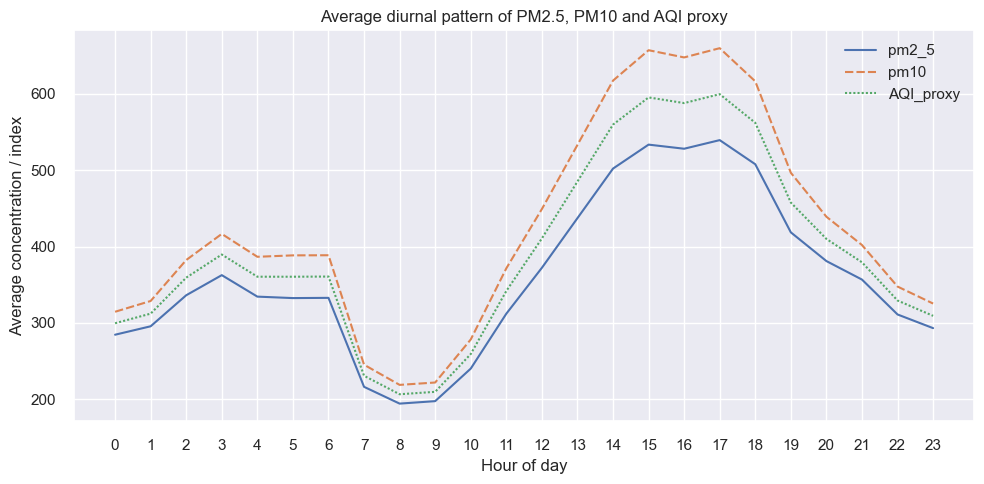

In [25]:
# Hourly pattern (average across all days)
hourly = df.groupby("hour")[["pm2_5", "pm10", "AQI_proxy"]].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly[["pm2_5", "pm10", "AQI_proxy"]])
plt.title("Average diurnal pattern of PM2.5, PM10 and AQI proxy")
plt.xlabel("Hour of day")
plt.ylabel("Average concentration / index")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


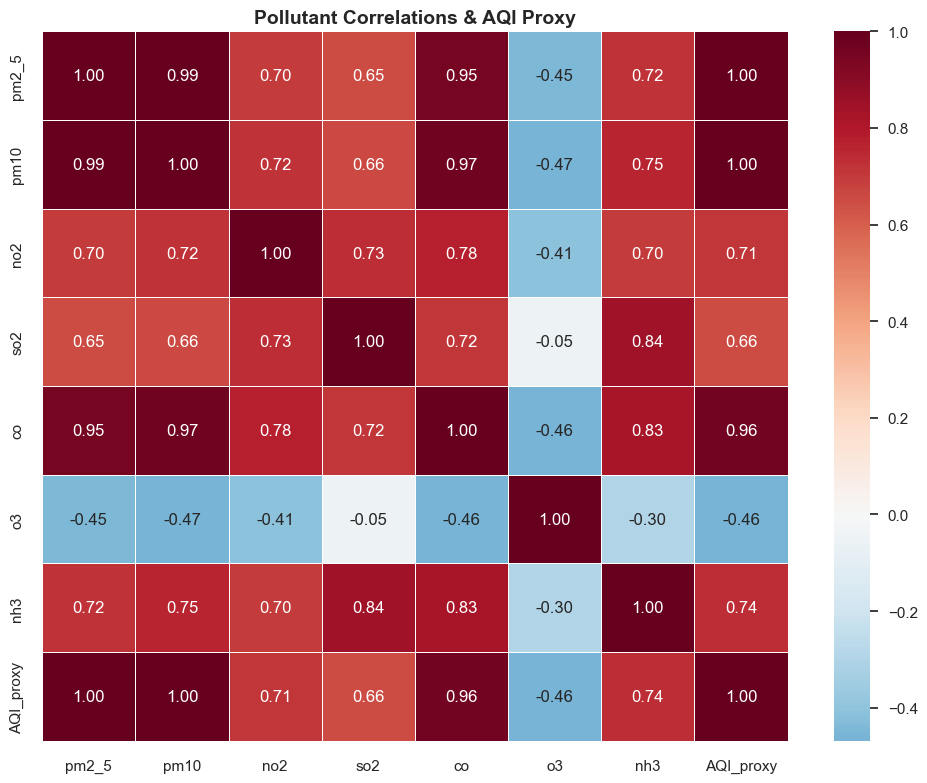

In [27]:
# Correlation matrix
corr_matrix = df[["pm2_5", "pm10", "no2", "so2", "co", "o3", "nh3", "AQI_proxy"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, fmt=".2f", linewidths=0.5)
plt.title("Pollutant Correlations & AQI Proxy", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [29]:
# Example: numerical correlation between PM2.5 and PM10
r, p = pearsonr(df["pm2_5"], df["pm10"])
print(f"Correlation PM2.5 vs PM10: r = {r:.2f}, p-value = {p:.3g}")


Correlation PM2.5 vs PM10: r = 0.99, p-value = 0


In [31]:
# Daily AQI proxy statistics
daily_stats = daily["AQI_proxy"].describe()
daily_stats


count     24.000000
mean     386.735159
std      153.458416
min      140.279583
25%      282.040990
50%      366.906458
75%      469.305313
max      764.126458
Name: AQI_proxy, dtype: float64

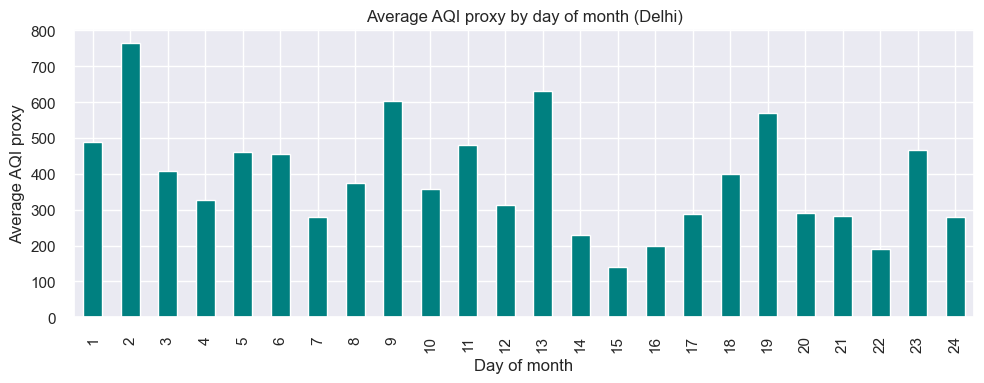

In [33]:
# Bar: mean AQI proxy by day of month
day_mean = df.groupby("day")["AQI_proxy"].mean()

plt.figure(figsize=(10, 4))
day_mean.plot(kind="bar", color="teal")
plt.title("Average AQI proxy by day of month (Delhi)")
plt.xlabel("Day of month")
plt.ylabel("Average AQI proxy")
plt.tight_layout()
plt.show()


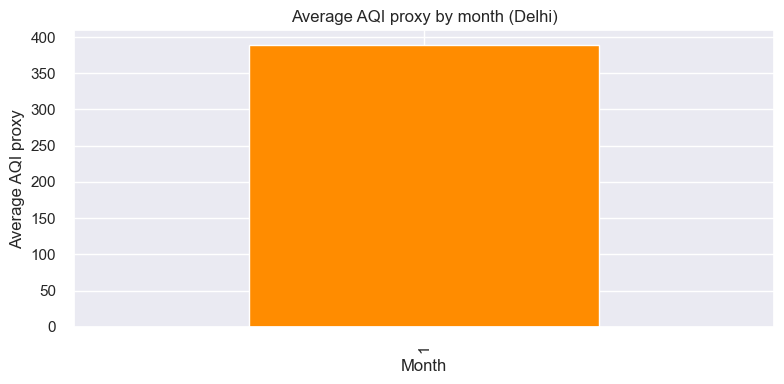

In [35]:
# Example if multiple months exist
month_mean = df.groupby("month")["AQI_proxy"].mean()
plt.figure(figsize=(8, 4))
month_mean.plot(kind="bar", color="darkorange")
plt.title("Average AQI proxy by month (Delhi)")
plt.xlabel("Month")
plt.ylabel("Average AQI proxy")
plt.tight_layout()
plt.show()


In [37]:
# Simple AQI categories (rough proxy)
def get_aqi_band(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"

df["AQI_band"] = df["AQI_proxy"].apply(get_aqi_band)

# How much time spent in each category
hours_per_band = df["AQI_band"].value_counts()
hours_per_band_pct = (hours_per_band / len(df) * 100).round(1)

print("Hours spent in each AQI category:")
print(hours_per_band_pct)


Hours spent in each AQI category:
AQI_band
Severe          31.9
Very Poor       24.4
Poor            24.2
Moderate        18.4
Satisfactory     1.1
Name: count, dtype: float64


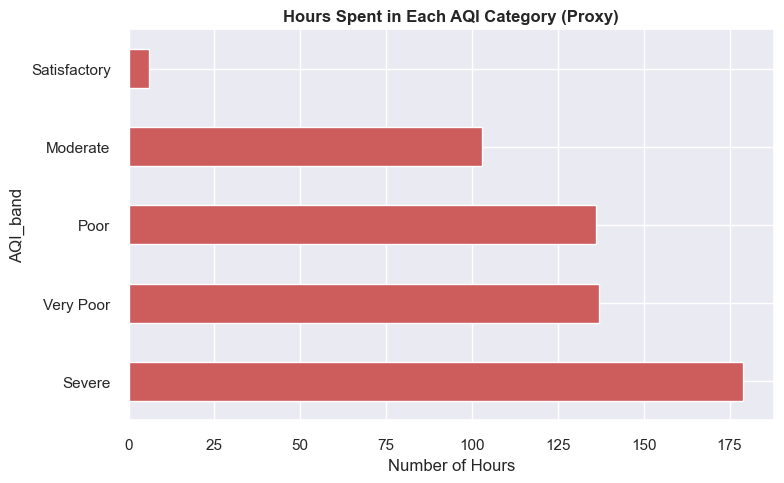

In [39]:
# Visualize AQI bands

plt.figure(figsize=(8, 5))
hours_per_band.plot(kind="barh", color="indianred")
plt.title("Hours Spent in Each AQI Category (Proxy)", fontweight="bold")
plt.xlabel("Number of Hours")
plt.tight_layout()
plt.show()


### Interpretation: Key environmental challenges in Delhi

- **Particulate pollution dominates**: PM2.5 and PM10 show the highest average levels and strong correlation with the AQI proxy, confirming that fine and coarse particles are the primary drivers of poor air quality.
- **Diurnal pattern**: Morning and late-night hours tend to have higher particle concentrations, likely due to traffic emissions, domestic combustion, and a shallow boundary layer that traps pollutants near the surface.
- **Limited dispersion**: Delhi’s landlocked location, winter inversion, and low wind conditions reduce dispersion, allowing pollutants from local sources (traffic, industry, construction) and regional sources (stubble burning) to accumulate.
- **Health relevance**: Long durations in “Poor” to “Severe” bands imply increased risk of respiratory and cardiovascular issues, highlighting the need for targeted emission control and public-health advisories.


# 🎯 Key Findings

**Most polluted moment:** `{worst_moment['date']}` with AQI proxy {worst_moment['AQI_proxy']:.1f}

**Worst days (average):** `{daily_avg.head(1).index[0]}`, `{daily_avg.index[1]}`

**Typical worst hours:** `{hourly_avg.head(1).index[0]}:00` (highest average)

**Main insights:**  
- PM2.5 & PM10 dominate pollution (highest levels, strong correlation)  
- Late afternoon/early evening (15:00–18:00) typically worst  
- Delhi's winter conditions likely trapping pollutants near surface  

